In [2]:
!pip install kaggle

In [3]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

# Move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 64 bytes


In [4]:
!kaggle datasets download "jangedoo/utkface-new"

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
utkface-new.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
!unzip utkface-new.zip

Streaming output truncated to the last 5000 lines.
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170109004755204.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170111182452832.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170103230340961.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104011329697.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104165020320.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170108230211421.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104022134829.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104023010725.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104172537171.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104201443273.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104204327

In [6]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, Input
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
BASE_DIR = '/content/UTKFace'


In [9]:
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [10]:
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

,image,age,gender
0,/content/UTKFace/10_1_0_20170109204259563.jpg....,10,1
1,/content/UTKFace/35_1_0_20170117174927240.jpg....,35,1
2,/content/UTKFace/47_0_3_20170117190238883.jpg....,47,0
3,/content/UTKFace/49_1_0_20170104184001972.jpg....,49,1
4,/content/UTKFace/40_0_0_20170117182249476.jpg....,40,0


In [11]:
gender_dict = {0:'Male', 1:'Female'}

<Axes: xlabel='gender', ylabel='Density'>

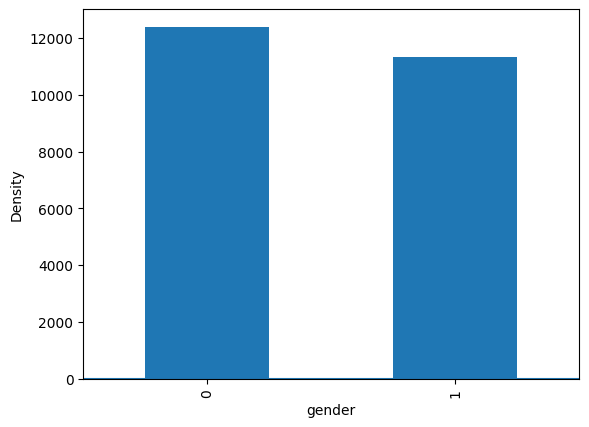

In [12]:
sns.distplot(df['age'])
df['gender'].value_counts().plot(kind='bar')



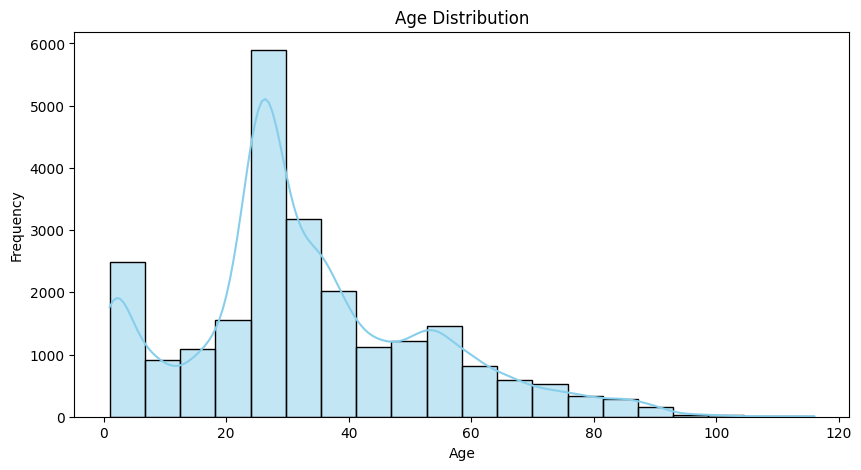

In [48]:
# Age Distribution
plt.figure(figsize=(10, 5))
sns.histplot(df['age'], bins=20, kde=True, color='skyblue')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

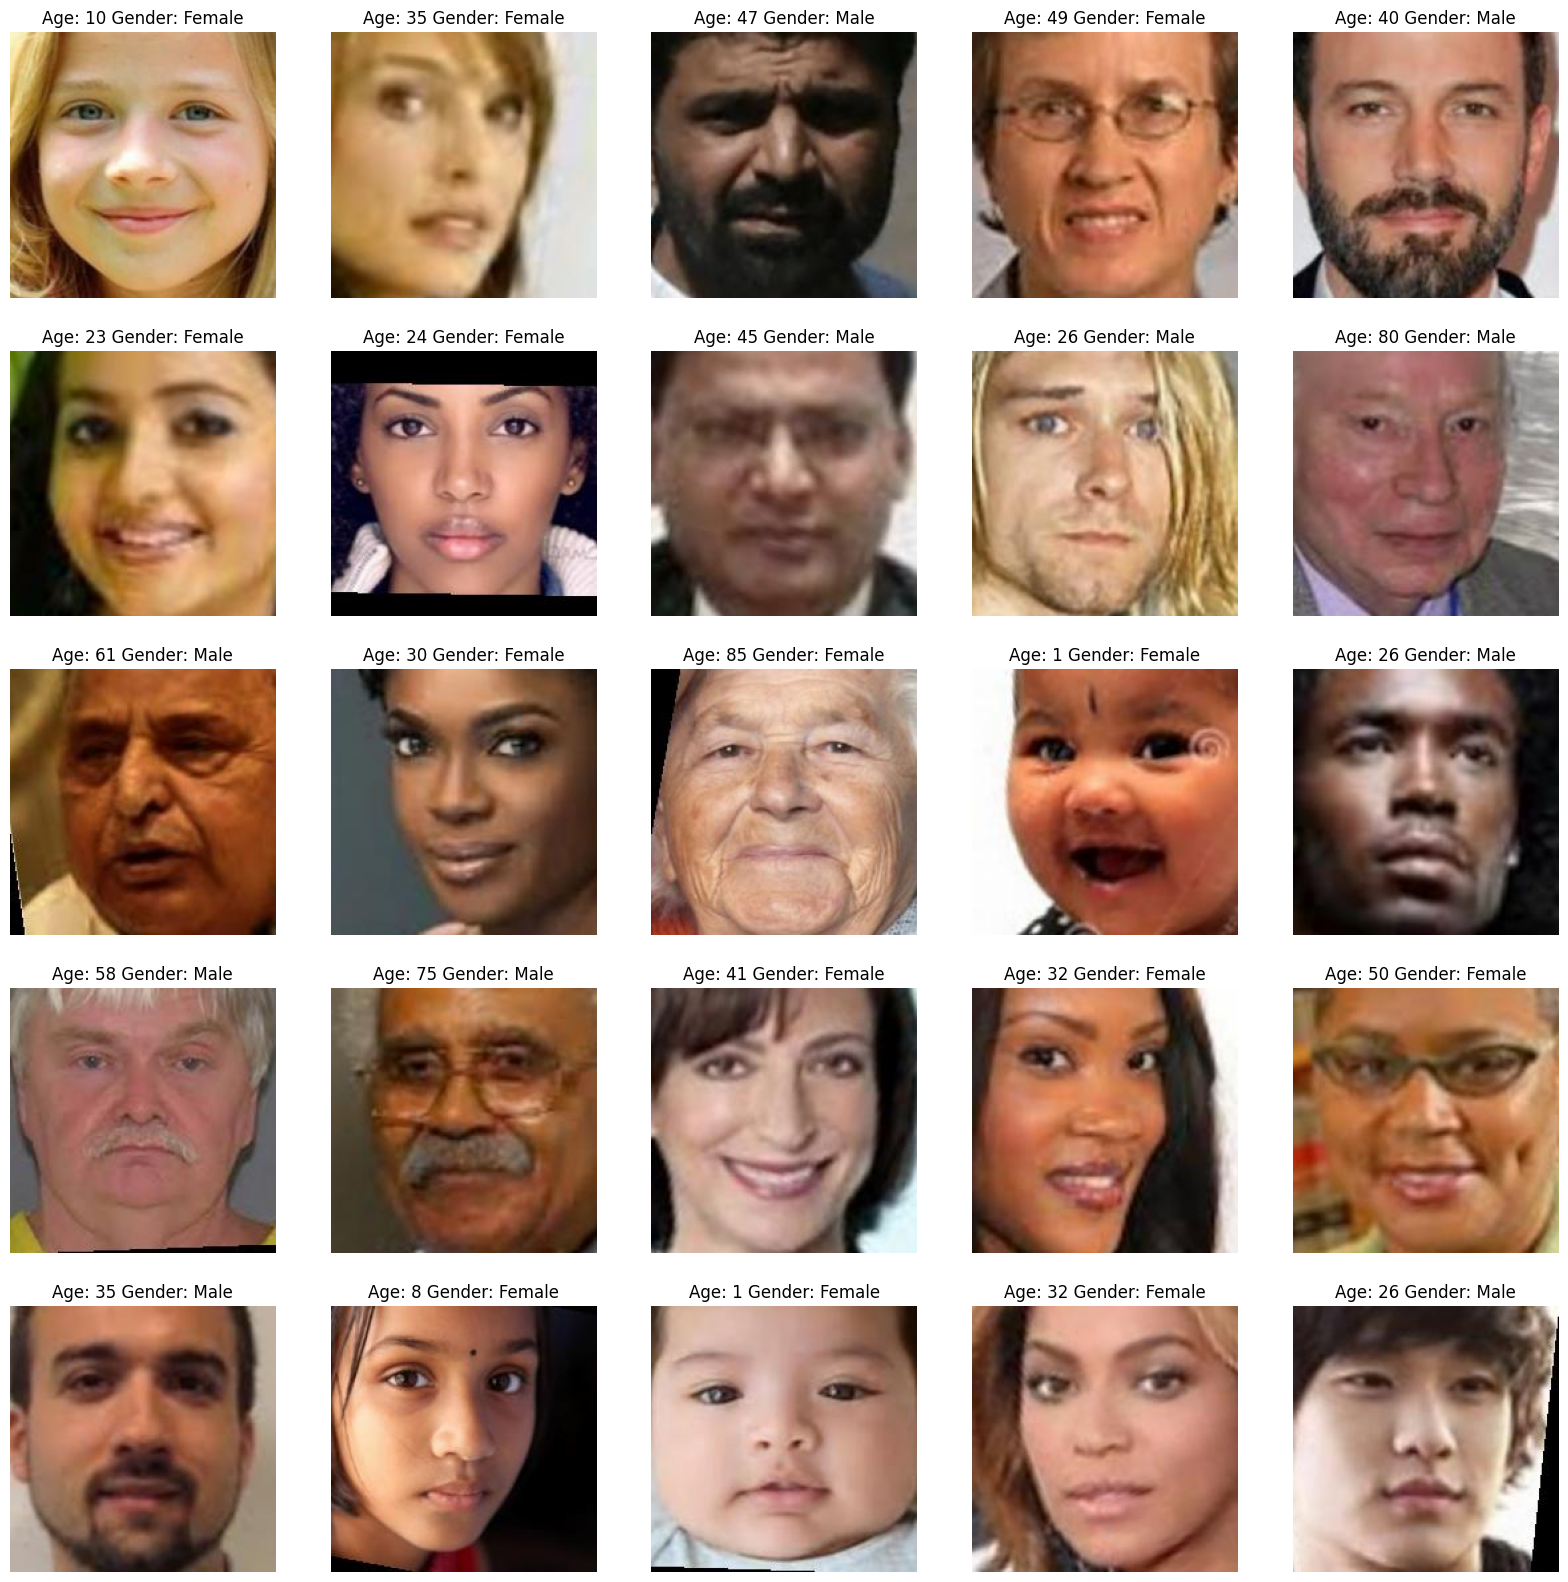

In [13]:
plt.figure(figsize=(20, 20))
files = df.iloc[0:25]
for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

In [30]:
def extract_features(df):
    image_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)
    train_gen = image_data_gen.flow_from_dataframe(
        dataframe=df,
        x_col='image',
        y_col=['gender', 'age'],
        target_size=(224, 224),
        batch_size=32,
        class_mode='multi_output',
        subset='training'
    )
    val_gen = image_data_gen.flow_from_dataframe(
        dataframe=df,
        x_col='image',
        y_col=['gender', 'age'],
        target_size=(224, 224),
        batch_size=32,
        class_mode='multi_output',
        subset='validation'
    )
    return train_gen, val_gen

train_generator, val_generator = extract_features(df)

Found 18967 validated image filenames.
Found 4741 validated image filenames.


In [31]:
input_shape = (224, 224, 3)
vgg = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

In [32]:
# Freeze the layers
for layer in vgg.layers:
    layer.trainable = False

inputs = vgg.input
x = vgg.output
x = Flatten()(x)

In [33]:
# Fully connected layers for gender prediction
gender_fc = Dense(256, activation='relu')(x)
gender_fc = Dropout(0.5)(gender_fc)
gender_output = Dense(1, activation='sigmoid', name='gender_out')(gender_fc)

In [34]:
# Fully connected layers for age prediction
age_fc = Dense(256, activation='relu')(x)
age_fc = Dropout(0.5)(age_fc)
age_output = Dense(1, activation='relu', name='age_out')(age_fc)

model = Model(inputs=inputs, outputs=[gender_output, age_output])

model.compile(optimizer='adam',
              loss={'gender_out': 'binary_crossentropy', 'age_out': 'mae'},
              metrics={'gender_out': 'accuracy', 'age_out': 'mae'})
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 224, 224, 64)         1792      ['input_3[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 224, 224, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)         0         ['block1_conv2[0][0]']        
                                                                                            

In [35]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Callbacks
checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True, mode='min')
earlystop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [36]:
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[checkpoint, earlystop]
)

Epoch 1/30
593/593 [==============================] - 149s 226ms/step - loss: 30.7232 - gender_out_loss: 0.7337 - age_out_loss: 29.9894 - gender_out_accuracy: 0.8226 - age_out_mae: 29.9894 - val_loss: 10.7030 - val_gender_out_loss: 0.3111 - val_age_out_loss: 10.3919 - val_gender_out_accuracy: 0.8692 - val_age_out_mae: 10.3919
Epoch 2/30
593/593 [==============================] - 127s 214ms/step - loss: 14.4070 - gender_out_loss: 0.2928 - age_out_loss: 14.1142 - gender_out_accuracy: 0.8741 - age_out_mae: 14.1142 - val_loss: 9.0127 - val_gender_out_loss: 0.2692 - val_age_out_loss: 8.7435 - val_gender_out_accuracy: 0.8872 - val_age_out_mae: 8.7435
Epoch 3/30
593/593 [==============================] - 127s 215ms/step - loss: 12.4375 - gender_out_loss: 0.2505 - age_out_loss: 12.1870 - gender_out_accuracy: 0.8886 - age_out_mae: 12.1870 - val_loss: 8.6962 - val_gender_out_loss: 0.2711 - val_age_out_loss: 8.4252 - val_gender_out_accuracy: 0.8802 - val_age_out_mae: 8.4252
Epoch 4/30
593/593 [==

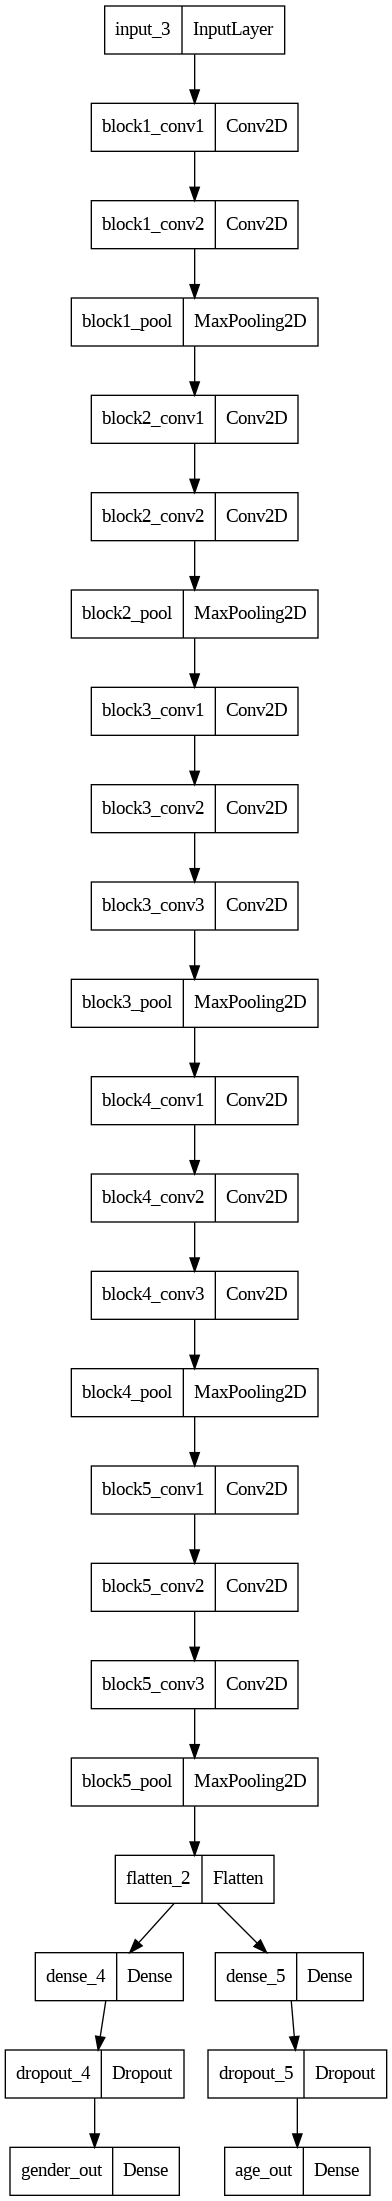

In [52]:
from tensorflow.keras.utils import plot_model
plot_model(model)

<Figure size 640x480 with 0 Axes>

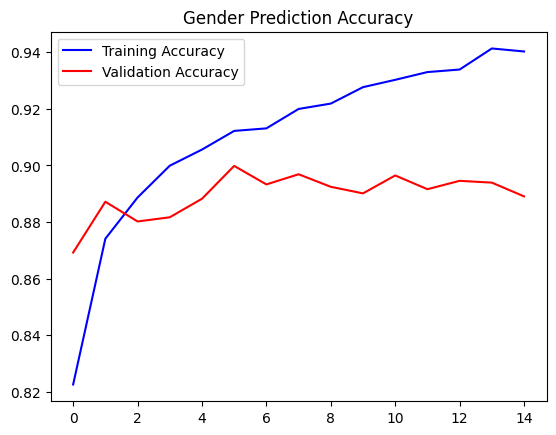

<Figure size 640x480 with 0 Axes>

In [37]:
# Plot results for gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Gender Prediction Accuracy')
plt.legend()
plt.figure()


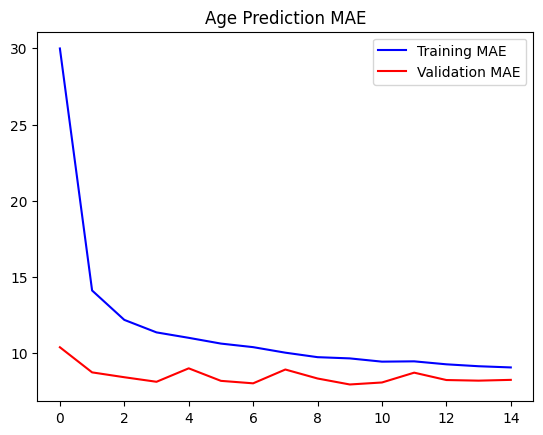

In [55]:
# Plot results for age
age_mae = history.history['age_out_mae']
val_age_mae = history.history['val_age_out_mae']

plt.plot(epochs, age_mae, 'b', label='Training MAE')
plt.plot(epochs, val_age_mae, 'r', label='Validation MAE')
plt.title('Age Prediction MAE')
plt.legend()
plt.show()



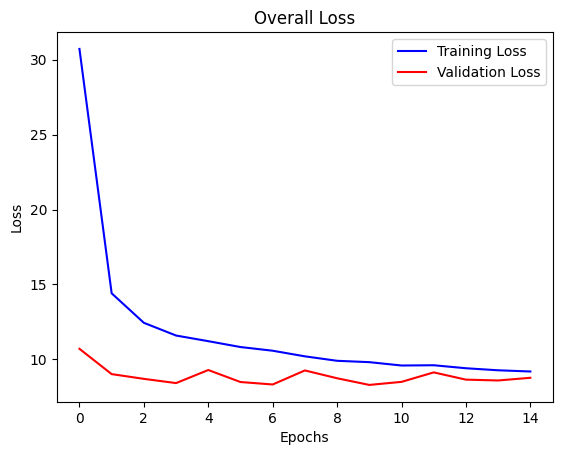

In [56]:
# Plot overall loss
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Overall Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Original Gender: Male Original Age: 20
1/1 [==============================] - 0s 23ms/step
Predicted Gender: Male Predicted Age: 16


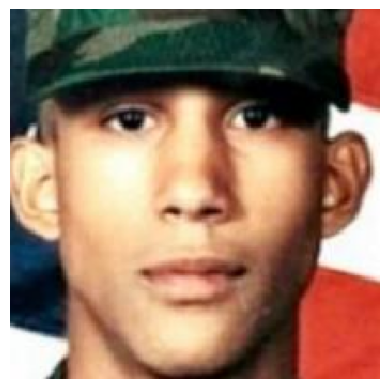

In [50]:
# Select an image index for prediction
image_index = 56

# Fetch the original values from the dataframe
original_gender = df.iloc[image_index]['gender']
original_age = df.iloc[image_index]['age']

print("Original Gender:", gender_dict[int(original_gender)], "Original Age:", original_age)

# Load and preprocess the image
img = load_img(df['image'][image_index], target_size=(224, 224))
img_array = np.array(img)
img_array = preprocess_input(img_array)
img_array = np.expand_dims(img_array, axis=0)

# Predict from model
pred = model.predict(img_array)
pred_gender = gender_dict[int(np.round(pred[0][0]))]
pred_age = int(np.round(pred[1][0]))

print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)

# Display the image
plt.axis('off')
plt.imshow(load_img(df['image'][image_index], target_size=(224, 224)))
plt.show()
